In [5]:
#Importing what we need
#remember to run this cell twice

%matplotlib notebook
import matplotlib.pyplot as plt

import mygrad as mg
import numpy as np
import os
import cv2 
import glob
from PIL import Image

In [6]:
#load database
path_to_train = "fruits-360/Training"
path_to_test = "fruits-360/Test"
Classes = []
for file in os.listdir(path_to_train):
    Classes.append(file)
# print(Classes)
print(len(Classes))

132


In [7]:
fruit_images = []
labels = [] 
# for fruit_dir_path in glob.glob(path_to_train):
for fruit_dir_path in glob.glob("fruits-360/Training/*"):
    fruit_label = fruit_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        fruit_images.append(image)
        labels.append(fruit_label)
fruit_images = np.array(fruit_images)
labels = np.array(labels)

In [8]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

In [9]:
label_ids = np.array([label_to_id_dict[x] for x in labels])

In [10]:
test_fruit_images = []
test_labels = [] 
for fruit_dir_path in glob.glob("fruits-360/Test/*"):
    fruit_label = fruit_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        test_fruit_images.append(image)
        test_labels.append(fruit_label)
test_fruit_images = np.array(test_fruit_images)
test_labels = np.array(test_labels)

In [12]:
test_label_ids = np.array([label_to_id_dict[x] for x in test_labels])


In [9]:

fruit_images = fruit_images.reshape((67692, 6075))
test_fruit_images = test_fruit_images.reshape((22688, 6075))


In [10]:
fruit_images = fruit_images.astype(float)
test_fruit_images = test_fruit_images.astype(float)
fruit_images /= 255.0
test_fruit_images /= 255.0

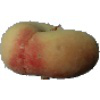

In [39]:
im = Image.open("fruits-360/Training/Peach Flat/1_100.jpg")
im

In [12]:
label_ids = label_ids.astype(int)
test_label_ids = test_label_ids.astype(int)

In [25]:
from mynn.optimizers.adam import Adam
from mynn.initializers.he_normal import he_normal
from mynn.activations.relu import relu
from mynn.losses.cross_entropy import softmax_cross_entropy
from mynn.layers.dense import dense
from mynn.layers.dropout import dropout


# Define your MyNN-`Model` class here. It should have:
# - an `__init__` method that initializes all of your layers
# - a `__call__` method that defines the model's "forward pass"
# - a `parameters` property that returns a tuple of all of your
#   model's learnable parameters (refer to the Tendrils-MyNN)
#   notebook for the syntax of defining a class-property)


class TrivialModel:
    def __init__(self, num_classes):
        """
        Initializes a model with two hidden layers of size `n1` and `n2`
        respectively.
        
        Parameters
        ----------
        n1 : int
            The number of neurons in the first hidden layer

        n2 : int
            The number of neurons in the second hidden layer
        
        num_classes : int
            The number of classes predicted by the model"""
        # STUDENT CODE HERE
        self.dense = dense(6075, num_classes, weight_initializer = he_normal)
        
    def __call__(self, x):
        '''Passes data as input to our model, performing a "forward-pass".
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor], shape=(M, 2)
            A batch of data consisting of M pieces of data,
            each with a dimentionality of 2.
            
        Returns
        -------
        mygrad.Tensor, shape=(M, num_out)
            The model's prediction for each of the M pieces of data.
        '''
        
        # We pass our data through a dense layer, use the activation 
        # function relu and then pass it through our second dense layer,
        # then use the activation function relu and then pass it through
        # our third dense layer.
        # We don't have a second activation function because it happens
        # to be included in our loss function: softmax-crossentropy
#         return self.dense5(self.dropout4(relu(self.dense3(self.dropout2(relu(self.dense1(x)))))))
        return self.dense(x)
        
    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.
        
        This can be accessed as an attribute, via `model.parameters` 
        
        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model"""
        return self.dense.parameters

In [26]:
# STUDENT CODE HERE
# learning_rate = 0.001
weight_decay = 5e-4
# n3 = 128
trivialmodel = TrivialModel(132)
optim = Adam(trivialmodel.parameters)

<IPython.core.display.Javascript object>


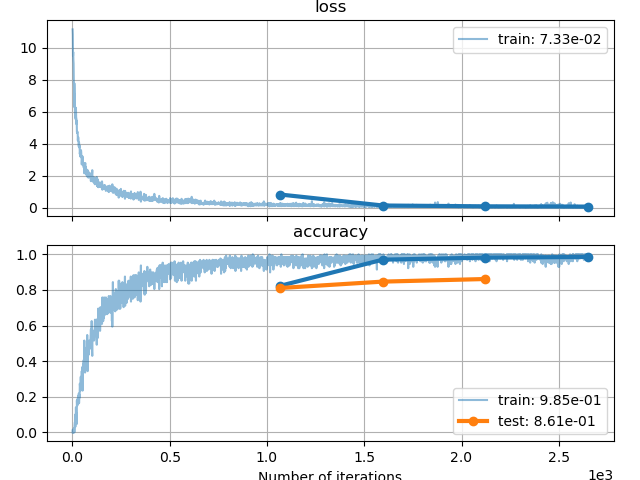

In [27]:
# Create a noggin plot, that keeps track of the metrics: "loss" and "accuracy"
# STUDENT CODE HERE
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

In [30]:
batch_size = 128
for epoch_cnt in range(4):
    indices = np.arange(0, len(fruit_images))
    np.random.shuffle(indices) 
    for batch_cnt in range(0, len(fruit_images) // batch_size):
        batch = fruit_images[indices[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]]
        prediction = trivialmodel(batch)
        truth = label_ids[indices[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]]
        loss = softmax_cross_entropy(prediction, truth)
        if isinstance(prediction, mg.Tensor):
            prediction = prediction.data
        predicted_class = np.argmax(prediction, axis=1)
        acc = np.mean(predicted_class == truth)
        loss.backward()
        optim.step()
        loss.null_gradients()

        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc}, batch_size=batch_size)
    test_idxs = np.arange(len(test_fruit_images))
    for batch_cnt in range(0, len(test_fruit_images)//batch_size):
        batch_indices = test_idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = test_fruit_images[batch_indices]
        truth = test_label_ids[batch_indices]
        prediction = trivialmodel(batch)
        if isinstance(prediction, mg.Tensor):
            prediction = prediction.data
        acc = np.mean(np.argmax(prediction, axis=1) == truth)
        # pass your test-accuracy here; we used the name `test_accuracy`
        plotter.set_test_batch({"accuracy" : acc}, batch_size=batch_size)
    plotter.set_train_epoch()
    plotter.set_test_epoch()

In [54]:
id_to_label_dict[15]

'Avocado ripe'

<IPython.core.display.Javascript object>


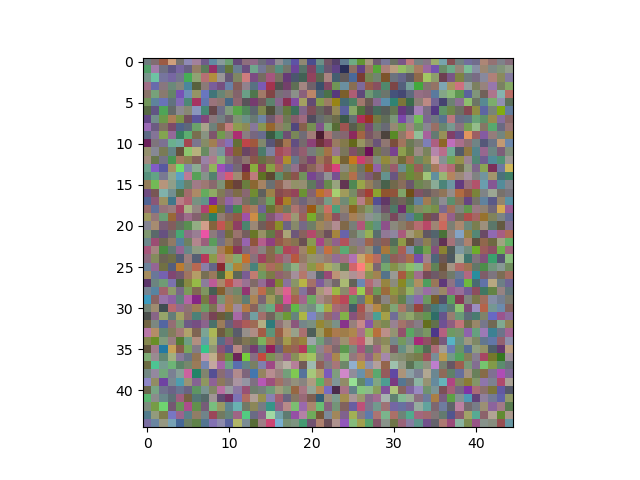

In [55]:
trivial_model_weights = trivialmodel.dense.weight.data.T
trivial_model_weights = trivial_model_weights.reshape((-1,45,45,3))[...,::-1]
minimum = np.min(trivial_model_weights, axis = (1,2,3), keepdims = True)
maximum = np.max(trivial_model_weights, axis = (1,2,3), keepdims = True)
trivial_model_weights = (trivial_model_weights - minimum)/(maximum - minimum)
fig, ax = plt.subplots()
ax.imshow(trivial_model_weights[15])

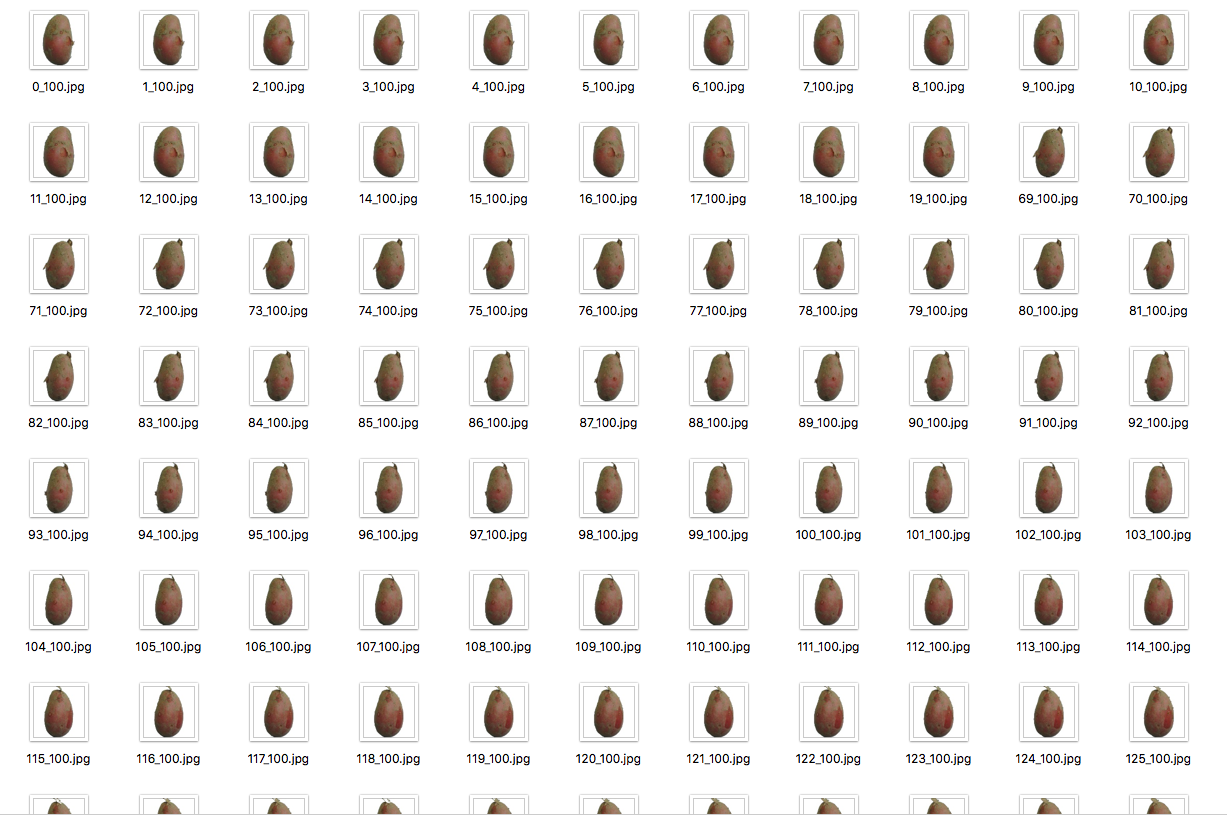

In [53]:
im = Image.open("Red Potato.jpg")
im

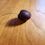

In [20]:
newimg = Image.open("test_cherry.jpg")
newimg

In [47]:
def make_prediction(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    image = cv2.resize(image, (45, 45))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    test_cherry_image = image
    test_cherry_image = np.array(test_cherry_image)
    test_cherry_image = test_cherry_image.reshape(1,6075)
    prediction = model(test_cherry_image)
    return id_to_label_dict[np.argmax(prediction)]

In [48]:
print(make_prediction("test_cherry.jpg"))

Pear Red


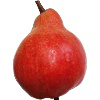

In [49]:
im = Image.open("fruits-360/Training/Pear Red/0_100.jpg")
im

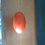

In [56]:
newimg = Image.open("test_tomato.jpg")
newimg

In [52]:
print(make_prediction("test_tomato.jpg"))]

Banana Red


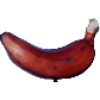

In [51]:
im = Image.open("fruits-360/Training/Banana Red/1_100.jpg")
im